Fit an exact GP to a medium number of samples of the Branin function.

In [1]:
from itertools import product
import numpy as np
import torch

def branin(X):
    x_1 = X[:, 0]
    x_2 = X[:, 1]
    return (
        (x_2 - 5.1 / (4 * np.pi ** 2) * x_1 ** 2 + 5.0 / np.pi * x_1 - 6.0) ** 2
        + 10 * (1 - 1.0 / (8 * np.pi)) * torch.cos(x_1)
        + 10
    )

x_grid = [-5, -2, 0, 2, 5, 10]
y_grid = [0, 3, 6, 9, 12, 15]
X = torch.Tensor(list(product(x_grid, y_grid)))
Y = branin(X)

In [2]:
import gpytorch

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

A function for optimizing a model with Adam, and another for L-BFGS.

In [3]:
# Fit with a Torch optimizer (Adam)

import time
from typing import Any, Dict, List, Optional, NamedTuple, Tuple

from gpytorch.mlls.marginal_log_likelihood import MarginalLogLikelihood
from gpytorch.module import Module
from scipy.optimize import minimize
from torch import Tensor
from torch.optim.adam import Adam
from torch.optim.optimizer import Optimizer


class OptimizationIteration(NamedTuple):
    itr: int
    fun: float
    time: float


def fit_torch(
    mll: MarginalLogLikelihood,
    optimizer_cls: Optimizer = Adam,
    lr: float = 0.05,
    maxiter: int = 100,
    optimizer_args: Optional[Dict[str, float]] = None,
    disp: bool = True,
    track_iterations: bool = True,
) -> Tuple[MarginalLogLikelihood, List[OptimizationIteration]]:
    """Fit a gpytorch model by maximizing MLL with a torch optimizer.

    The model and likelihood in mll must already be in train mode.

    Args:
        mll: MarginalLogLikelihood to be maximized.
        optimizer_cls: Torch optimizer to use. Must not need a closure.
            Defaults to Adam.
        lr: Starting learning rate.
        maxiter: Maximum number of iterations.
        optimizer_args: Additional arguments to instantiate optimizer_cls.
        disp: Print information during optimization.
        track_iterations: Track the function values and wall time for each
            iteration.

    Returns:
        mll: mll with parameters optimized in-place.
        iterations: List of OptimizationIteration objects describing each
            iteration. If track_iterations is False, will be an empty list.
    """
    optimizer_args = {} if optimizer_args is None else optimizer_args
    optimizer = optimizer_cls(
        params=[{"params": mll.model.parameters()}], lr=lr, **optimizer_args
    )

    iterations = []
    t1 = time.time()

    param_trajectory: Dict[str, List[Tensor]] = {
        name: [] for name, param in mll.model.named_parameters()
    }
    loss_trajectory: List[float] = []
    for i in range(maxiter):
        optimizer.zero_grad()
        output = mll.model(mll.model.train_inputs[0])
        # we sum here to support batch mode
        loss = -mll(output, mll.model.train_targets).sum()
        loss.backward()
        loss_trajectory.append(loss.item())
        for name, param in mll.model.named_parameters():
            param_trajectory[name].append(param.detach().clone())
        if disp and (i % 10 == 0 or i == (maxiter - 1)):
            print(f"Iter {i +1}/{maxiter}: {loss.item()}")
        if track_iterations:
            iterations.append(OptimizationIteration(i, loss.item(), time.time() - t1))
        optimizer.step()
    return mll, iterations

In [4]:
# With torch L-BFGS

import sys
sys.path.append('../../PyTorch-LBFGS/functions/')
from LBFGS import LBFGS
#from pytorch_lbfgs.functions.LBFGS import LBFGS

def fit_lbfgs(
    mll: MarginalLogLikelihood,
    maxiter: int = 10,
    disp: bool = True,
    track_iterations: bool = True,
) -> Tuple[MarginalLogLikelihood, List[OptimizationIteration]]:
    """Fit a gpytorch model by maximizing MLL with pytorch LBFGS.

    The model and likelihood in mll must already be in train mode.

    Args:
        mll: MarginalLogLikelihood to be maximized.
        maxiter: Maximum number of iterations.
        optimizer_args: Additional arguments to instantiate optimizer_cls.
        disp: Print information during optimization.
        track_iterations: Track the function values and wall time for each
            iteration.

    Returns:
        mll: mll with parameters optimized in-place.
        iterations: List of OptimizationIteration objects describing each
            iteration. If track_iterations is False, will be an empty list.
    """

    optimizer = LBFGS(mll.model.parameters())

    iterations = []
    t1 = time.time()

    optimizer.zero_grad()
    output = mll.model(*mll.model.train_inputs)
    # we sum here to support batch mode
    loss = -mll(output, mll.model.train_targets).sum()
    loss.backward()
    # get gradient
    grad = optimizer._gather_flat_grad()

    for i in range(maxiter):

        # compute search direction
        p = optimizer.two_loop_recursion(-grad)

        def closure():
            optimizer.zero_grad()
            output = mll.model(*mll.model.train_inputs)
            loss = -mll(output, mll.model.train_targets).sum()
            return loss

        # Take the step
        options = {'closure': closure, 'current_loss': loss, 'max_ls': 10}
        loss, grad, lr, _, F_eval, G_eval, _, _ = optimizer.step(p, grad, options=options)
        optimizer.curvature_update(grad)

        if disp:
            print(f"Iter {i +1}/{maxiter}: {loss.item()}")
        if track_iterations:
            iterations.append(OptimizationIteration(i, loss.item(), time.time() - t1))

    return mll, iterations

ModuleNotFoundError: No module named 'LBFGS'

#### Adam
Adam is very sensitive to the learning rate. The default value of 0.001 hardly moves at all on this problem. Values less than 1 are very slow, but values slightly larger than 1 lead to errors.

In [10]:
# Adam with a few lengthscales
adam_iterations = {}
for lr in [0.1, 0.5, 1.0]:
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = ExactGPModel(X, Y, likelihood)
    likelihood.train()
    model.train()
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    mll, adam_iterations[lr] = fit_torch(
        mll,
        optimizer_cls=torch.optim.Adam,
        lr=lr,
        track_iterations=True,
    )

Iter 1/100: 2194.351318359375
Iter 11/100: 559.5626831054688
Iter 21/100: 264.2170715332031
Iter 31/100: 176.5773162841797
Iter 41/100: 122.60818481445312
Iter 51/100: 94.59010314941406
Iter 61/100: 78.50749969482422
Iter 71/100: 67.56319427490234
Iter 81/100: 59.17941665649414
Iter 91/100: 52.584327697753906
Iter 100/100: 47.65000915527344
Iter 1/100: 2194.35888671875
Iter 11/100: 68.37015533447266
Iter 21/100: 16.545494079589844
Iter 31/100: 9.84347152709961
Iter 41/100: 8.171196937561035
Iter 51/100: 7.551003456115723
Iter 61/100: 7.24299430847168
Iter 71/100: 7.0498456954956055
Iter 81/100: 6.90476655960083
Iter 91/100: 6.7870097160339355
Iter 100/100: 6.692652225494385
Iter 1/100: 2194.356201171875
Iter 11/100: 11.227054595947266
Iter 21/100: 5.838791847229004
Iter 31/100: 5.710531711578369
Iter 41/100: 5.751251697540283
Iter 51/100: 5.774423122406006
Iter 61/100: 5.782119274139404
Iter 71/100: 5.782623291015625
Iter 81/100: 5.780119895935059
Iter 91/100: 5.776400566101074
Iter 10

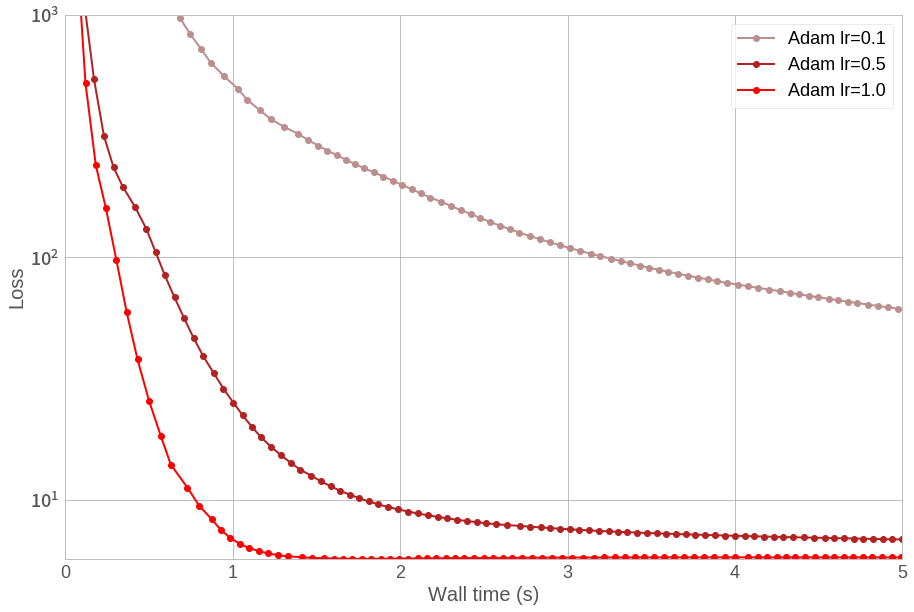

In [11]:
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111)
colors = ['rosybrown', 'firebrick', 'red']
lrs = [0.1, 0.5, 1.0]
names = [f'Adam lr={lr}' for lr in lrs]


res = [adam_iterations[lr] for lr in lrs]

for i, iterations in enumerate(res):
    ts = [itr.time for itr in iterations]
    fs = [itr.fun for itr in iterations]
    ax.semilogy(ts, fs, '.-', color=colors[i], lw=2, ms=12)

ax.legend(names, fontsize=18)
ax.set_ylim([0, 1000])
ax.set_xlim([0, 5])
ax.set_ylabel('Loss', fontsize=20)
ax.set_xlabel('Wall time (s)', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=18)

But if we use Adam with a learning rate of 3, it errors.

In [12]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(X, Y, likelihood)
likelihood.train()
model.train()
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

mll, adam_iterations[lr] = fit_torch(
    mll,
    optimizer_cls=torch.optim.Adam,
    lr=3.,
    track_iterations=True,
)

Iter 1/100: 2194.35546875


RuntimeError: Lapack Error in potrf : the leading minor of order 5 is not positive definite at caffe2/aten/src/TH/generic/THTensorLapack.cpp:668

#### L-BFGS
L-BFGS does not require tuning the learning rate, but can take too large of steps early on while it is still learning the curvature. On this problem it fails when evaluating the closure for the first time.

In [13]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(X, Y, likelihood)
likelihood.train()
model.train()
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

mll, lbfgs_iterations = fit_lbfgs(mll, track_iterations=True)

RuntimeError: Lapack Error in potrf : the leading minor of order 1 is not positive definite at caffe2/aten/src/TH/generic/THTensorLapack.cpp:668